In [1]:
import gzip
import pickle
import struct

import matplotlib.pyplot as plt
import numpy as np
from array import array as pyarray

import pandas as pd
from scipy.ndimage import interpolation
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from KBisMean import bkmeans
from exec2 import sammon


In [2]:

def dataSet0(size):
    def moments(image):
        """
        https://fsix.github.io/mnist/Deskewing.html
        :param image:
        :return:
        """
        c0, c1 = np.mgrid[:image.shape[0], :image.shape[1]
                          ]  # A trick in numPy to create a mesh grid
        totalImage = np.sum(image)  # sum of pixels
        m0 = np.sum(c0 * image) / totalImage  # mu_x
        m1 = np.sum(c1 * image) / totalImage  # mu_y
        m00 = np.sum((c0 - m0) ** 2 * image) / totalImage  # var(x)
        m11 = np.sum((c1 - m1) ** 2 * image) / totalImage  # var(y)
        m01 = np.sum((c0 - m0) * (c1 - m1) * image) / \
            totalImage  # covariance(x,y)
        # Notice that these are \mu_x, \mu_y respectively
        mu_vector = np.array([m0, m1])
        # Do you see a similarity between the covariance matrix
        covariance_matrix = np.array([[m00, m01], [m01, m11]])
        return mu_vector, covariance_matrix

    def deskew(image):
        """
        https://fsix.github.io/mnist/Deskewing.html
        :param image:
        :return:
        """
        c, v = moments(image)
        alpha = v[0, 1] / v[0, 0]
        affine = np.array([[1, 0], [alpha, 1]])
        ocenter = np.array(image.shape) / 2.0
        offset = c - np.dot(affine, ocenter)
        return interpolation.affine_transform(image, affine, offset=offset)

    def loadMNIST(imagePath, labelPath, size=1000, digits=np.arange(10)):
        """

        :param imagePath:
        :param labelPath:
        :param size:
        :param digits:
        :return:
        """
        N = size

        with gzip.open(labelPath, 'rb') as finf:
            magic_nr, size = struct.unpack(">II", finf.read(8))
            lbl = pyarray("b", finf.read())

            ind = [k for k in range(size) if lbl[k] in digits]
            labels = np.zeros((N, 1), dtype=np.int8)
            for i in range(N):
                labels[i] = lbl[ind[i]]
            finf.close()

        with gzip.open(imagePath, 'rb') as fimg:
            magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
            img = pyarray("B", fimg.read())

            ind = [k for k in range(size) if lbl[k] in digits]
            images = np.zeros((N, rows * cols), dtype=np.float)

            for i in range(N):  # int(len(ind) * size/100.)):
                images[i] = np.array(img[ind[i] * rows * cols: (ind[i] + 1) * rows * cols]) \
                    .reshape((rows * cols)) / 255.0

            fimg.close()

        labels = [label[0] for label in labels]
        return images, labels

    MNISTImgTrain = "./datasets/digits/train-images-idx3-ubyte.gz"
    MNISTLabelTrain = "./datasets/digits/train-labels-idx1-ubyte.gz"
    MNISTImg = "./datasets/digits/t10k-images-idx3-ubyte.gz"
    MNISTLabel = "./datasets/digits/t10k-labels-idx1-ubyte.gz"

    X, y = loadMNIST(MNISTImgTrain, MNISTLabelTrain, size=size[0])
    Xt, yt = loadMNIST(MNISTImg, MNISTLabel, size=size[1])

    XSkewed = np.array(
        [deskew(_x.reshape(28, 28)).reshape(X[0].shape) for _x in X])
    tXSkewed = np.array(
        [deskew(_x.reshape(28, 28)).reshape(X[0].shape) for _x in Xt])

    return XSkewed, y, tXSkewed, yt, "digits"


def dataSet1(size):
    def loadMNIST(imagePath, labelPath, size=(1000, 100), digits=np.arange(10)):
        """

        :param imagePath:
        :param labelPath:
        :param size:
        :param digits:
        :return:
        """
        N = size

        with gzip.open(labelPath, 'rb') as finf:
            magic_nr, size = struct.unpack(">II", finf.read(8))
            lbl = pyarray("b", finf.read())

            ind = [k for k in range(size) if lbl[k] in digits]
            labels = np.zeros((N, 1), dtype=np.int8)
            for i in range(N):
                labels[i] = lbl[ind[i]]
            finf.close()

        with gzip.open(imagePath, 'rb') as fimg:
            magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
            img = pyarray("B", fimg.read())

            ind = [k for k in range(size) if lbl[k] in digits]
            images = np.zeros((N, rows * cols), dtype=np.float)

            for i in range(N):  # int(len(ind) * size/100.)):
                images[i] = np.array(img[ind[i] * rows * cols: (ind[i] + 1) * rows * cols]) \
                    .reshape((rows * cols)) / 255.0

            fimg.close()

        labels = [label[0] for label in labels]
        return images, labels

    MNISTImgTrain = "./datasets/fashion/train-images-idx3-ubyte.gz"
    MNISTLabelTrain = "./datasets/fashion/train-labels-idx1-ubyte.gz"
    MNISTImg = "./datasets/fashion/t10k-images-idx3-ubyte.gz"
    MNISTLabel = "./datasets/fashion/t10k-labels-idx1-ubyte.gz"

    X, y = loadMNIST(MNISTImgTrain, MNISTLabelTrain, size=size[0])
    Xt, yt = loadMNIST(MNISTImg, MNISTLabel, size=size[1])

    # XSkewed = np.array([deskew(_x.reshape(28, 28)).reshape(X[0].shape) for _x in X])
    # tXSkewed = np.array([deskew(_x.reshape(28, 28)).reshape(X[0].shape) for _x in Xt])

    return X, y, Xt, yt, "fashion"


def dataSet2(size):
    print("Ignoring size request")
    df = pd.read_csv('datasets/leaf.csv', header=None).sample(frac=1)
    #
    X = np.array(df.drop(columns=[0, 1], axis=1), dtype=np.float)
    y = np.array(df.loc[:, 0])

    assert len(X) == len(y)

    return X, y, None, None, 'Leaf'


def loadDataSet(nth=0, training_size=1000, testing_size=100):
    dat = [dataSet0, dataSet1, dataSet2]
    return dat[nth](size=(training_size, testing_size))


# Check all datasets
def displaySampleData():
    plt.figure(figsize=(20, 4))
    for i in range(0, 3):
        X, y, tx, ty, l = loadDataSet(i, training_size=10, testing_size=1)
        for index, (image, label) in enumerate(zip(X[0:5], y[0:5])):
            p_ = plt.subplot(3, 5, (i * 5) + (index + 1))
            p_.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray)
            p_.set_title('Training: {}\n'.format(label), fontsize=20)
    plt.title("Example of data set elements")
    plt.suptitle("Examples")
    plt.show()


/tmp/ipykernel_126248/3820303732.py:62: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = np.zeros((N, rows * cols), dtype=np.float)
/tmp/ipykernel_126248/3820303732.py:34: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  return interpolation.affine_transform(image, affine, offset=offset)


Starting on dataset 'digits'


ModuleNotFoundError: No module named 'sklearn.decomposition.pca'

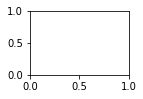

In [3]:

# displaySampleData()

drPickles = ['exec3_{}_DR_model.sav'.format(i) for i in range(0, 10)]
ClusterPickles = ['exec3_{}_CL_model.sav'.format(i) for i in range(0, 10)]

# DR techniques
for i in range(0, 3):  # Iterate data sets.
    X, y, tx, ty, name = loadDataSet(i, 500, 50)
    n_samples = len(X)
    n_features = len(X[0])

    print("Starting on dataset '{}'".format(name))
    for j in range(0, 3):  # Iterate DR techniques.
        filename = drPickles[i * 3 + j]
        plti = plt.subplot(3, 3, (i * 3) + j + 1)
        if j == 0:  # PCA

            # Generate new PCA or load.
            try:
                with open(filename, 'rb') as f:
                    pca = pickle.load(f)
            except FileNotFoundError as f:
                n_components = min(n_samples, n_features)
                pca = PCA(n_components=3)
                pca.fit(X, y)
                pickle.dump(pca, open(filename, 'wb'))

            pca_result = pca.transform(X)
            ax = plti

            pca0 = pca_result[:, 0]
            pca1 = pca_result[:, 1]
            pca2 = pca_result[:, 2]

            ax.scatter(
                x=pca0, y=pca1,
                c=y,
                alpha=0.3)
            ax.set_xlabel('PCA-one')
            ax.set_ylabel('PCA-two')
            plti.set_title("PCA - {}".format(name))

        elif j == 1:  # t-SNE
            colors = ['r', 'g', 'b', 'c', 'm',
                      'y', 'k', 'w', 'orange', 'purple']

            # Generate new t-SNE or load.
            try:
                with open(filename, 'rb') as f:
                    tsne = pickle.load(f)
            except FileNotFoundError as f:
                tsne = TSNE(n_components=2, random_state=0,
                            verbose=1, perplexity=40, n_iter=300)
                tsne.fit(X)
                pickle.dump(tsne, open(filename, 'wb'))

            tsne_results = tsne.fit_transform(X)
            tsne0 = tsne_results[:, 0]
            tsne1 = tsne_results[:, 1]

            target_ids = range(len(y))
            for _i, label in zip(target_ids, y):
                plti.scatter(x=tsne0, y=tsne1,
                             c=y,
                             alpha=0.3)
            plti.set_title("t-SNE - {}".format(name))

        elif j == 2:  # Sammon mapping.
            result = sammon(X, 250, 0.035, 0.1)
            sammon0 = result[:, 0]
            sammon1 = result[:, 1]
            plti.scatter(x=sammon0, y=sammon1,
                         c=y,
                         alpha=0.3)
            plti.set_title("Sammon mapping - {}".format(name))

plt.title("Dimension Reduction")
plt.suptitle("Dimension Reduction")
plt.show()


In [ ]:

# Cluster techniques
# Bisecting k-Means with classic k-Means and hierarchical clustering for each data set
for i in range(0, 3):
    X, y, tx, ty, name = loadDataSet(i)
    pcaModelFilePath = ClusterPickles[i]
    k = 5
    try:
        with open(pcaModelFilePath, 'rb') as f:
            pca = pickle.load(f)
    except Exception as err:
        pca = PCA(n_components=2)
        pca.fit(X)
        pickle.dump(pca, open(pcaModelFilePath, 'wb'))

    pca_result = pca.fit_transform(X)
    #pca_test = pca.transform(tx)

    pca0 = pca_result[:, 0]
    pca1 = pca_result[:, 1]

    for j in range(0, 3):
        plti = plt.subplot(3, 3, i * 3 + j + 1)
        if j == 0:
            plti.set_title("Hierarchical Clustering - {}".format(name))
            clus = AgglomerativeClustering(n_clusters=k)
            clus.fit(pca_result, y)
            plti.scatter(x=pca0, y=pca1, c=clus.labels_, alpha=0.3)
            #l = clus.fit_predict(pca_test)
        elif j == 1:
            plti.set_title("K Mean - {}".format(name))
            kmean = KMeans(n_jobs=-1, n_clusters=k, random_state=True)
            kmean.fit(pca_result, y)
            plti.scatter(x=pca0, y=pca1, c=kmean.labels_, alpha=0.3)
        elif j == 2:
            plti.set_title("Bisecting K Mean - {}".format(name))
            labels = bkmeans(pca_result, k, 30)
            plti.scatter(x=pca0, y=pca1, c=labels, alpha=0.3)

plt.title("Cluster Reduction")
plt.suptitle("Cluster Reduction")
plt.show()
